In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

2023-06-25 16:18:31.135240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 16:18:31.716207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Read the csv file
df = pd.read_csv('/home/anil/Documents/GE.csv')
print(df.head()) #7 columns, including the Date. 

         Date       Open       High        Low      Close  Adj Close    Volume
0  2022-06-24  50.476189  53.060108  50.288837  52.365341  52.139313  12805260
1  2022-06-27  52.669788  53.005463  51.631538  52.076504  51.913635   8708622
2  2022-06-28  52.654175  53.434818  51.022640  51.428570  51.267727   9029385
3  2022-06-29  51.311474  51.522247  49.398907  49.718971  49.563473   8849404
4  2022-06-30  48.829041  49.773613  48.212334  49.703358  49.547909  11147134


In [3]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.

236   2023-06-02
237   2023-06-05
238   2023-06-06
239   2023-06-07
240   2023-06-08
241   2023-06-09
242   2023-06-12
243   2023-06-13
244   2023-06-14
245   2023-06-15
246   2023-06-16
247   2023-06-20
248   2023-06-21
249   2023-06-22
250   2023-06-23
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [5]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [6]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [7]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

In [8]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [9]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [10]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [11]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


2023-06-25 16:18:51.708973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 16:18:51.741445: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5
14/14 [==============================] - 2s 27ms/step - loss: 0.4445 - val_loss: 1.0127
Epoch 2/5
14/14 [==============================] - 0s 9ms/step - loss: 0.1254 - val_loss: 0.1061
Epoch 3/5
14/14 [==============================] - 0s 9ms/step - loss: 0.0760 - val_loss: 0.0722
Epoch 4/5
14/14 [==============================] - 0s 9ms/step - loss: 0.0560 - val_loss: 0.1171
Epoch 5/5
14/14 [==============================] - 0s 9ms/step - loss: 0.0409 - val_loss: 0.0182


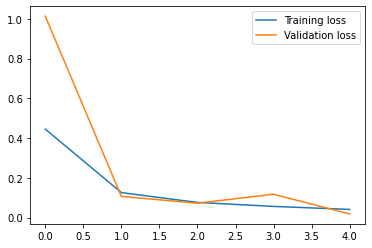

In [12]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [13]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])




[Timestamp('2023-06-01 00:00:00', freq='C'), Timestamp('2023-06-02 00:00:00', freq='C'), Timestamp('2023-06-05 00:00:00', freq='C'), Timestamp('2023-06-06 00:00:00', freq='C'), Timestamp('2023-06-07 00:00:00', freq='C'), Timestamp('2023-06-08 00:00:00', freq='C'), Timestamp('2023-06-09 00:00:00', freq='C'), Timestamp('2023-06-12 00:00:00', freq='C'), Timestamp('2023-06-13 00:00:00', freq='C'), Timestamp('2023-06-14 00:00:00', freq='C'), Timestamp('2023-06-15 00:00:00', freq='C'), Timestamp('2023-06-16 00:00:00', freq='C'), Timestamp('2023-06-20 00:00:00', freq='C'), Timestamp('2023-06-21 00:00:00', freq='C'), Timestamp('2023-06-22 00:00:00', freq='C')]
1/1 [==============================] - 0s 178ms/step


/tmp/ipykernel_10095/3987748712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<AxesSubplot: xlabel='Date', ylabel='Open'>

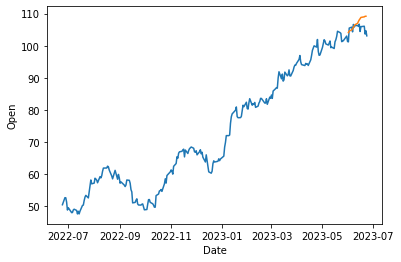

In [14]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(x=original['Date'], y=original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])